In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
# Check current directory
current_directory = os.getcwd()

# Specify the file path
file_name = "tiki.csv"
file_path = os.path.join(current_directory, file_name)
df = pd.read_csv(file_path)
print(df.dtypes)
print(df.head())

Link        object
Name        object
Brand       object
Price       object
Sale        object
Stars      float64
Coupon      object
5 stars    float64
4 stars    float64
3 stars    float64
2 stars    float64
1 star     float64
Reviews     object
dtype: object
                                                Link  \
0  https://tiki.vn/bo-noi-inox-3-day-sunhouse-sh3...   
1  https://tiki.vn/bo-noi-inox-3-day-sunhouse-sh3...   
2  https://tiki.vn/noi-hap-inox-3-tang-p129143705...   
3  https://tiki.vn/chao-chong-dinh-inox-day-tu-ng...   
4  https://tiki.vn/chao-sau-long-nag2653-day-tu-5...   

                                                Name     Brand     Price  \
0  Bộ Nồi Inox 3 Đáy Sunhouse SH335(16cm, 20cm, ...  Sunhouse  445.000₫   
1                   Bộ Nồi Inox 3 Đáy Sunhouse SH334  Sunhouse  536.000₫   
2                                Nồi Hấp Inox 3 Tầng       OEM  132.000₫   
3  Chảo chống dính Inox đáy từ nguyên khối đáy li...    Elmich  331.000₫   
4  Chảo Sâu Lòng NAG26

In [3]:
# CLEAN DATA
# Delete empty reviews 
df['Reviews'] = df['Reviews'].astype(str)
reviews = df[['Reviews']]
for index, row in df.iterrows():
    reviews_array = row['Reviews']  # Access the 'Reviews' array for each row
    # Remove square brackets and split into individual reviews
    reviews = reviews_array[2:-2].split("', '")
    new_review = []
    for review in reviews:
        if review == "":
            new_review.append(review)
    row['Reviews'] = new_review


In [4]:
# Add danh muc
df.loc[:9, 'Category'] = 'Dụng cụ nhà bếp'
df.loc[10:19, 'Category'] = 'Trang trí nhà cửa'
df.loc[20:29, 'Category'] = 'Đồ dùng phòng ngủ'
df.loc[30:39, 'Category'] = 'Ngoài trời sân vườn'
df.loc[40:49, 'Category'] = 'Đồ nội thất'

In [5]:
# Convert numerical data to number (price, stars, sale)
# Convert price to int
df['Price'] = df['Price'].astype(str) # turn object to str
df['Price'] = df['Price'].str.replace(r'\D', '', regex=True).astype(float) # remove character

# Convert sale to int
df['Sale'] = df['Sale'].astype(str) # turn object to str
df['Sale'] = df['Sale'].str.replace(r'\D', '', regex=True).astype(float) # remove character

# Convert the '5 stars', .. '1 star' column to integers only if it's not null,
df[['5 stars', '4 stars', '3 stars', '2 stars', '1 star']] = df[['5 stars', '4 stars', '3 stars', '2 stars', '1 star']].apply(
    lambda x: pd.to_numeric(x, errors='coerce').astype(float)
) 

In [6]:
columns_with_nan = df.columns[df.isnull().any()].tolist()

if len(columns_with_nan) > 0:
    print(f"Columns with NaN values: {columns_with_nan}")
else:
    print("No columns have NaN values.")
print(df.dtypes)

Columns with NaN values: ['Stars', 'Coupon', '5 stars', '4 stars', '3 stars', '2 stars', '1 star']
Link         object
Name         object
Brand        object
Price       float64
Sale        float64
Stars       float64
Coupon       object
5 stars     float64
4 stars     float64
3 stars     float64
2 stars     float64
1 star      float64
Reviews      object
Category     object
dtype: object


In [7]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Replace NaN with mean for numerical columns (except 'Coupon')
for col in numerical_cols:
    if col != 'Coupon':
        col_mean = df[col].mean()
        df[col].fillna(col_mean, inplace=True)

# Replace NaN in 'Coupon' column with ['']
df['Coupon'].fillna('['']', inplace=True)

print(df)

                                                 Link  \
0   https://tiki.vn/bo-noi-inox-3-day-sunhouse-sh3...   
1   https://tiki.vn/bo-noi-inox-3-day-sunhouse-sh3...   
2   https://tiki.vn/noi-hap-inox-3-tang-p129143705...   
3   https://tiki.vn/chao-chong-dinh-inox-day-tu-ng...   
4   https://tiki.vn/chao-sau-long-nag2653-day-tu-5...   
5   https://tiki.vn/bo-noi-xung-hap-28cm-dung-duoc...   
6   https://tiki.vn/bo-dao-nha-bep-nhat-6-mon-cao-...   
7   https://tiki.vn/bo-noi-inox-1-day-sunhouse-sh2...   
8   https://tiki.vn/chao-nhom-sau-long-chong-dinh-...   
9   https://tiki.vn/bo-noi-5-day-cao-cap-num-vang-...   
10  https://tiki.vn/nen-thom-trang-tri-phong-cach-...   
11  https://tiki.vn/dong-ho-de-ban-led-bao-thuc-th...   
12  https://tiki.vn/dong-ho-bao-thuc-dien-tu-de-ba...   
13  https://tiki.vn/tham-long-trai-san-long-min-ki...   
14  https://tiki.vn/nen-thom-candle-cup-agaya-huon...   
15  https://tiki.vn/sap-nen-thom-dot-phong-nen-hoa...   
16  https://tiki.vn/vo-tat-nhun

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

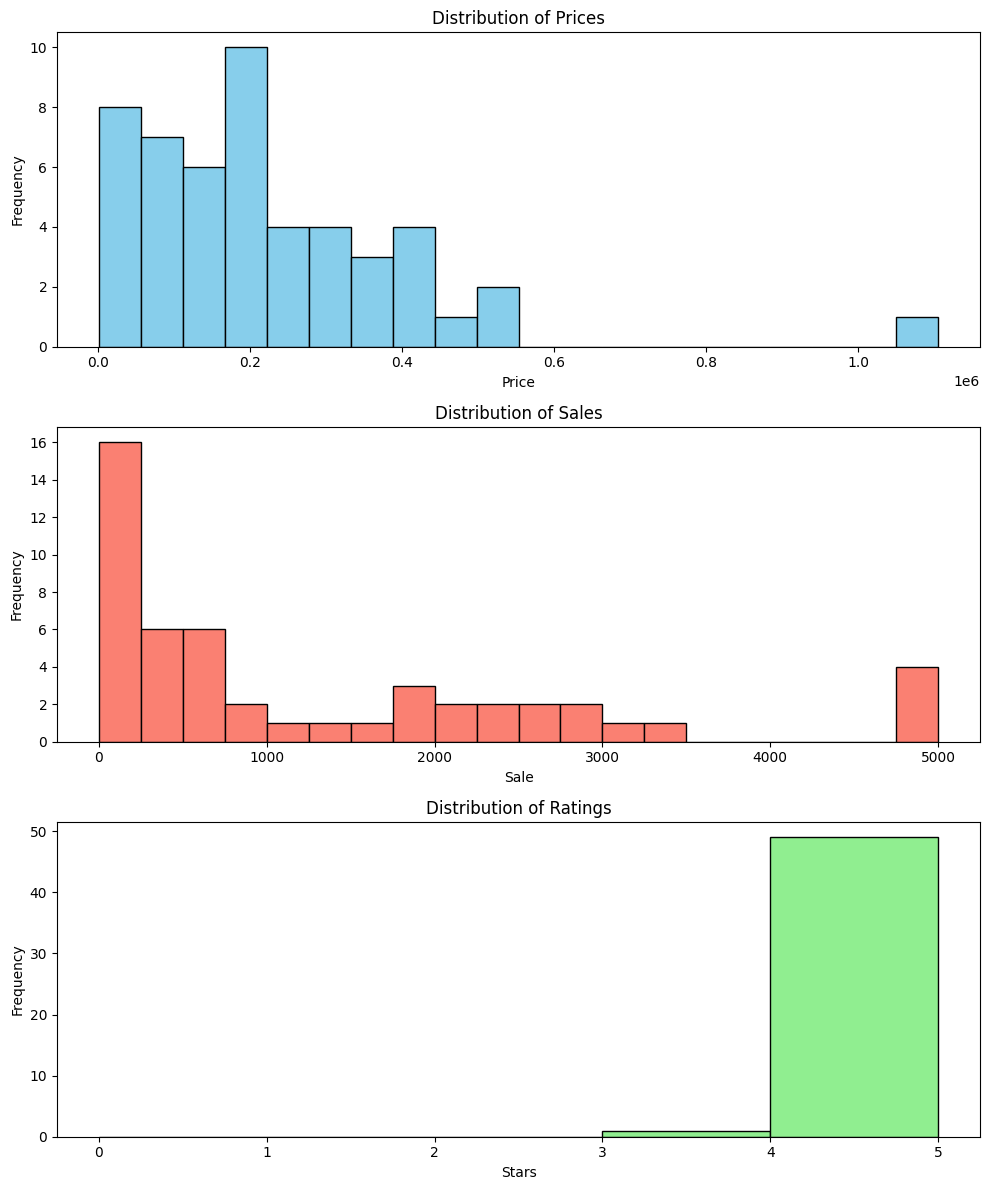

In [9]:
# DESCRIPTIVE STATISTICS
# Plot histograms
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Histogram for 'Price'
axes[0].hist(df['Price'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Histogram for 'Sale'
axes[1].hist(df['Sale'].dropna(), bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Sales')
axes[1].set_xlabel('Sale')
axes[1].set_ylabel('Frequency')

# Histogram for 'Stars'
axes[2].hist(df['Stars'].dropna(), bins=5, range=(0, 5), color='lightgreen', edgecolor='black')
axes[2].set_title('Distribution of Ratings')
axes[2].set_xlabel('Stars')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [10]:
# Summary count, mean, std, min, max, 25% quantile, 50% quantile, 75% quantile 
selected_columns = ['Price', 'Sale', 'Stars']

summary_table = df[selected_columns].describe().transpose()

# Display the summary table
print("Summary Statistics:")
print(summary_table)

Summary Statistics:
       count           mean            std     min      25%            50%  \
Price   50.0  224097.820000  189062.398407  1800.0  90500.0  184500.000000   
Sale    50.0    1314.200000    1477.710073     1.0    189.5     574.000000   
Stars   50.0       4.673913       0.228066     3.9      4.5       4.673913   

            75%        max  
Price  325000.0  1105000.0  
Sale     2141.0     5000.0  
Stars       4.8        5.0  


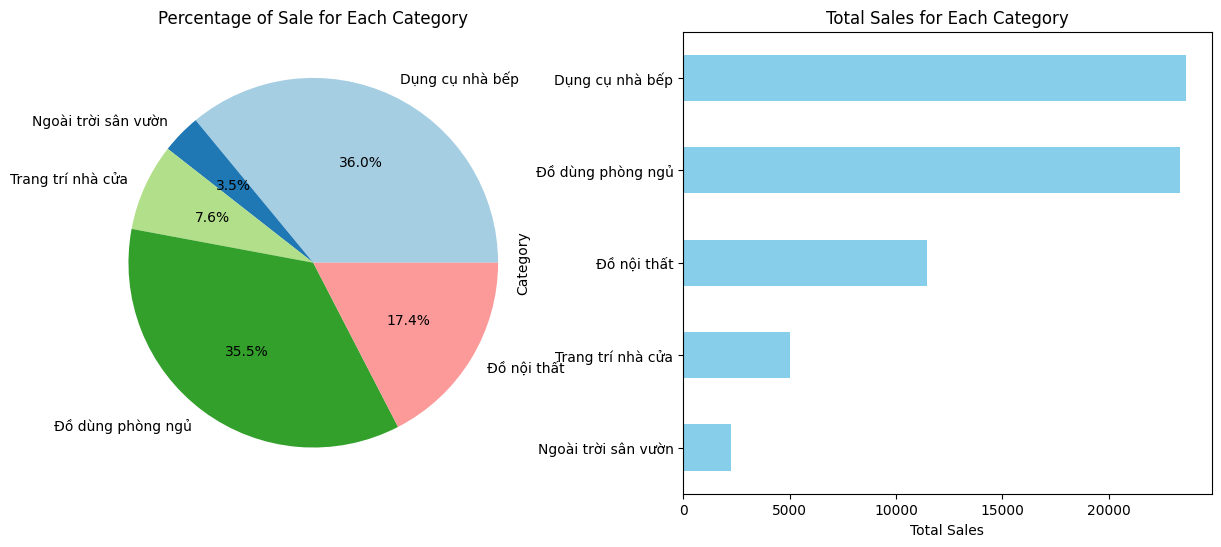

In [11]:
# What is the percentage of sale for each category?
# What is the total sales for each category?
df['Sale'] = pd.to_numeric(df['Sale'], errors='coerce')  # Convert 'Sale' column to numeric

# Group by 'Category' and calculate the sum of sales for each category
category_sales = df.groupby('Category')['Sale'].sum()

# Calculate the total sale for all categories
total_sale = category_sales.sum()

# Calculate the percentage of sale for each category
percentage_sale = (category_sales / total_sale) * 100

# Plot the pie chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Pie chart
axes[0].pie(percentage_sale, labels=percentage_sale.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set_title('Percentage of Sale for Each Category')
axes[0].set_ylabel('')  # Remove the default 'Category' label

# Bar chart
category_sales.sort_values().plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Total Sales for Each Category')
axes[1].set_xlabel('Total Sales')

plt.show()

In [12]:
# Which is the Best Selling Product in Each Country
df['Sale'] = pd.to_numeric(df['Sale'], errors='coerce')  # Convert 'Sale' column to numeric

# Group by 'Category' and find the best-selling product in each category
best_selling_products = df.loc[df.groupby('Category')['Sale'].idxmax()]

# Display the result in a simple table format
print("Best Selling Product in Each Category:")
print("{:<20} {:<40} {:<10}".format("Category", "Name", "Sale"))
for index, row in best_selling_products.iterrows():
    print("{:<20} {:<40} {:<10}".format(row['Category'], row['Name'], row['Sale']))

Best Selling Product in Each Category:
Category             Name                                     Sale      
Dụng cụ nhà bếp      Bộ Nồi Inox 3 Đáy Sunhouse SH335(16cm, 20cm, 24cm ) - Dùng trên mọi loại bếp - Hàng chính hãng 5000.0    
Ngoài trời sân vườn  Muỗng Đong Định Lượng Greenhome, 2 Đầu, Chia Vạch Sẵn, Tiện Lợi, Đong Phân Bón Dạng Bột, Gia Vị 565.0     
Trang trí nhà cửa    Nến thơm hoa khô thiên nhiên, sáp nến thơm phòng MO hi cao cấp - Hàng chính hãng, giao màu, hình, họa tiết hộp ngẫu nhiên 1598.0    
Đồ dùng phòng ngủ    Gối Memory Foam 50D Hình Cong Lock&Lock HLW111 (50 x 30 cm) - Trắng 5000.0    
Đồ nội thất          Bàn Làm Việc Phong Cách Bắc Âu Thương Hiệu IGEA (Không Bao Gồm Ghế) 2863.0    


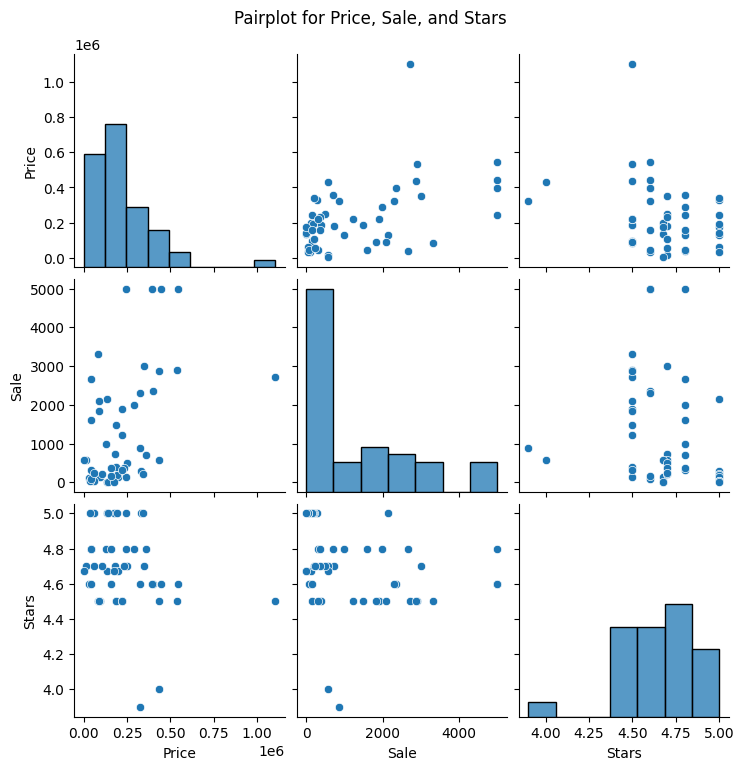

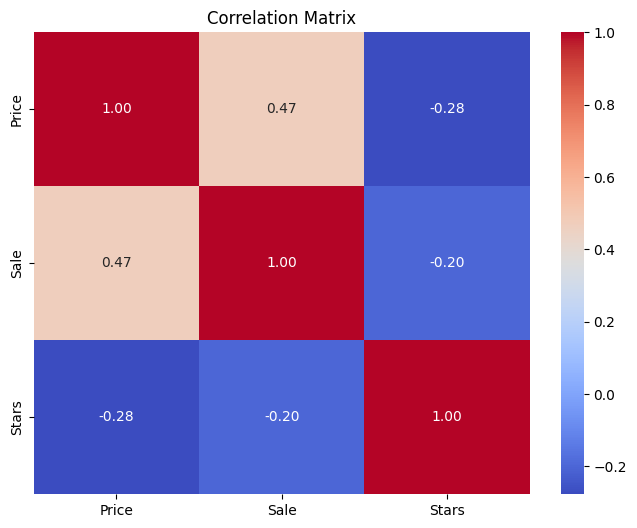

In [13]:
# STATISTICAL CALCULATIONS
# Correlations: Check correlations between variables like 'Price', 'Sale', 'Stars', and 'Reviews' to understand relationships
sns.pairplot(df[selected_columns].dropna())
plt.suptitle("Pairplot for Price, Sale, and Stars", y=1.02)
plt.show()

# Correlation matrix
correlation_matrix = df[selected_columns].corr()

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [16]:
# TRAINING MODEL
# Random Forest Regression: Predicting sales ('Sale') like 'Price', 'Brand', 'Reviews'.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X = df.drop('Sale', axis=1)
y = df['Sale']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define columns to be treated differently (categorical and numerical columns)
categorical_cols = ['Brand', 'Coupon', 'Category']
numerical_cols = ['Price', 'Stars', '5 stars', '4 stars', '3 stars', '2 stars', '1 star']

# Preprocessing steps
numerical_transformer = SimpleImputer(strategy='mean')  # Handle missing numerical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical data
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create a pipeline that bundles preprocessing and modeling
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)
                          ])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
predictions = pipeline.predict(X_test)

print(y_test)
print(predictions)

13     381.0
39      77.0
30     565.0
45       9.0
17     576.0
48     241.0
26    1895.0
25    3321.0
32     144.0
19      46.0
Name: Sale, dtype: float64
[ 669.2   158.7   891.26  883.84  409.    206.36  308.4  2923.98  250.34
  270.69]


In [ ]:
# from sklearn.metrics import mean_absolute_error

# # Evaluate the model
# mae = mean_absolute_error(y_test, predictions)
# print(f"Mean Absolute Error (MAE): {mae}")

# # Calculate Percentage Error for each prediction
# percentage_errors = (abs(y_test - predictions) / y_test) * 100

# # Average Percentage Error
# average_percentage_error = percentage_errors.mean()
# print(f"Average Percentage Error: {average_percentage_error:.2f}%")

In [19]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 20],
    # Add more hyperparameters to tune
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate with the best model found during hyperparameter tuning
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Get feature importances
feature_importances = best_model.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

NameError: name 'mean_absolute_error' is not defined

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(40, 13)
(10, 13)
(40,)
(10,)
